<a href="https://colab.research.google.com/github/sio-co2o2/scrippsco2_notebooks/blob/main/notebooks/plot_global_co2_stations_scrippsco2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/sio-co2o2/scrippsco2_notebooks/main?labpath=notebooks%2Fplot_global_co2_stations_scrippsco2.ipynb)

# Plot CO2 concentration trends from global stations 

### Scripps CO2 Program
https://scrippsco2.ucsd.edu

This notebook creates pdf and png plot versions.

## Import packages

In [1]:
import re
import pandas as pd
import numpy as np
import requests
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
import os
from PIL import Image

%matplotlib inline

In [ ]:
# This package is used to convert a vector svg into a png

try:
  from cairosvg import svg2png
except:
  ! pip install cairosvg
  from cairosvg import svg2png

In [ ]:
# This import is to enable Google Colab to save files ane then download them

# This import does not exist unless the notebook is run in Google Colab
# Put in a try except block if user wants to use notebook off of Google Colab

try:
    from google.colab import files
except:
    pass

## Set directories and file names for data,  plot, and logo

In [2]:
# Data from scrippsco2.ucsd.edu
insitu_data_dir = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly'
merged_data_dir = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/merged_in_situ_and_flask/monthly'
flask_data_dir = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/flask_co2/monthly'

# Data from bluemoon
# insitu_data_dir = 'data/to_post/in_situ_co2/monthly'
# merged_data_dir = 'data/to_post/merged_in_situ_and_flask/monthly'
# flask_data_dir = 'data/to_post/flask_co2/monthly'

# Place in order want to plot  from bottom to top
stations = ['spo', 'sam', 'chr', 'mlo', 'ljo', 'ptb']

station_urls = {}

monthly_ptb_file = 'monthly_merge_co2_ptb.csv'
station_urls['ptb'] = f"{merged_data_dir}/{monthly_ptb_file}"

monthly_ljo_file = 'monthly_merge_co2_ljo.csv'
station_urls['ljo'] = f"{merged_data_dir}/{monthly_ljo_file}"

monthly_mlo_file = 'monthly_in_situ_co2_mlo.csv'
station_urls['mlo'] = f"{insitu_data_dir}/{monthly_mlo_file}" 

monthly_chr_file = 'monthly_flask_co2_chr.csv'
station_urls['chr'] = f"{flask_data_dir}/{monthly_chr_file}"

monthly_sam_file = 'monthly_flask_co2_sam.csv'
station_urls['sam'] = f"{flask_data_dir}/{monthly_sam_file}"

monthly_spo_file = 'monthly_merge_co2_spo.csv'
station_urls['spo'] = f"{merged_data_dir}/{monthly_spo_file}"

# Set plot directories for website graphics gallery
plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

plot_pdf_dir = pathlib.Path(plot_dir / 'pdf')
plot_pdf_dir.mkdir(exist_ok=True)

plot_png_dir = pathlib.Path(plot_dir / 'png')
plot_png_dir.mkdir(exist_ok=True)

plot_display_dir = pathlib.Path(plot_dir / 'display')
plot_display_dir.mkdir(exist_ok=True)

plot_thumbnail_dir = pathlib.Path(plot_dir / 'thumbnails')
plot_thumbnail_dir.mkdir(exist_ok=True)

# logo_file = 'images/ucsd_sio_logo.svg'

logo_file = 'https://github.com/sio-co2o2/keelingcurve_notebooks/raw/main/images/logos/ucsd_sio_logo.svg'

plot_name = 'co2_sta_records'

pdf_file = plot_pdf_dir / f'{plot_name}.pdf'
png_file = plot_png_dir / f'{plot_name}.png'
png_display_file = plot_display_dir / f'{plot_name}.png'
png_thumbnail_file = plot_thumbnail_dir / f'{plot_name}.png'


## Load in Data and process

#### Look at the file comments to see what the columns represent (same for all stations)

In [3]:
mlo_url = station_urls['mlo']

# Load from URL
response = requests.get(mlo_url)
file_text = response.text
text_lines = file_text.split('\n')

# Load from file
# with open(mlo_url) as f:
#     text_lines = f.readlines()

# From looking at the file, the column description comments start with
# the words 'The data file below'
comments = [line for line in text_lines if line.startswith('"')]

search_str = 'The data file below'
desc_line_start = [index for index, comment in enumerate(comments) if search_str in comment]

if desc_line_start:
    col_desc = comments[desc_line_start[0]:]
    print('\n'.join(col_desc))

" The data file below contains 10 columns.  Columns 1-4 give the dates in several redundant "
" formats. Column 5 below gives monthly Mauna Loa CO2 concentrations in micro-mol CO2 per   "
" mole (ppm), reported on the 2012 SIO manometric mole fraction scale.  This is the        "
" standard version of the data most often sought.  The monthly values have been adjusted    "
" to 24:00 hours on the 15th of each month.  Column 6 gives the same data after a seasonal  "
" adjustment to remove the quasi-regular seasonal cycle.  The adjustment involves           "
" subtracting from the data a 4-harmonic fit with a linear gain factor.  Column 7 is a      "
" smoothed version of the data generated from a stiff cubic spline function plus 4-harmonic "
" functions with linear gain.  Column 8 is the same smoothed version with the seasonal      "
" cycle removed.  Column 9 is identical to Column 5 except that the missing values from     "
" Column 5 have been filled with values from Column 7.  Colum

### Load in station data

In [4]:
station_dfs =  {}

for station in stations:
    data_url = station_urls[station]
    station_dfs[station] = pd.read_csv(data_url,sep=',',comment='"', skipinitialspace=True)

station_dfs['mlo'].head()

,Yr,Mn,Date,Date.1,CO2,seasonally,fit,seasonally.1,CO2.1,seasonally.2,Sta
0,NaN,NaN,NaN,NaN,NaN,adjusted,NaN,adjusted fit,filled,adjusted filled,NaN
1,NaN,NaN,Excel,NaN,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958.0,1.0,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958.0,2.0,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958.0,3.0,21259,1958.2027,315.71,314.43,316.20,314.90,315.71,314.43,MLO


## Define functions to appply to each CO2 record for processing

#### To plot, want the decimal date (col 4) along with CO2 (col 5) and CO2 fit (col 7)
Due to the column headers spread over 3 lines and the top line repeating col names, pandas denotes the identical string with a subscript.

#### Function to rename the columns for Pandas and the user

In [5]:
def rename_dataframe_cols(df):
    # Rename column names to replace duplicate names
    col_mapping ={df.columns[0]:'year', df.columns[1]: 'month', df.columns[2]: 'excel_date', 
              df.columns[3]: 'dec_date', df.columns[4]: 'co2', df.columns[5]: 'co2_seasonal',
              df.columns[6]: 'co2_fit', df.columns[7]: 'co2_seasonal_fit', 
              df.columns[8]:'co2_filled', df.columns[9]: 'co2_seasonal_filled'}
    df = df.rename(columns=col_mapping)
    
    return df

### There are 3 header lines and will skip the 2nd and 3rd along with renaming the first header line cols

Start at index 2 since the first line became the column header

In [6]:
def remove_extra_headers(df):
    df = df.iloc[2:]

    # reset index
    df = df.reset_index(drop=True)

    return df


### The data fits can extend beyond the data end points, so will remove this

In [7]:
def remove_endpoint_nans(df, elem):

    # reset index
    df = df.reset_index(drop=True)

    # Since read in strings from the extra header lines, convert columns back to numeric values
    df = df.apply(pd.to_numeric, errors='coerce')

    # The spline fit extends past the data, and for the plot,
    # will want both the data and spline fit to have the same endpoints
    # Find row indices extending past data point

    # Replace -99.99 with np.nan so can do the following
    # checks to remove splines extending past endpoints
    df = df.replace(-99.99, np.nan)

    # First find the row index of the last finite value
    last_finite_elem_index = df[elem].last_valid_index()

    # Then drop rows past this row index
    df = df.drop(df.index[(last_finite_elem_index+1):])

    # Do the same for the beginning of the spline
    # Remove any points before the first point
    first_finite_elem_index = df[elem].first_valid_index()

    # Then drop rows before this row index
    df = df.drop(df.index[:(first_finite_elem_index)])

    # reset index
    df = df.reset_index(drop=True)

    return df


### Remove fit from plot if gap more than 12 months

In [8]:
def flag_fit_gaps(df, elem):

    # Fill NaN with fixed value so can easily
    # compare if values are the same across rows
    df_hold = df.fillna(-99.99)

    # Drop rows that have > 2 same values
    labels = (df_hold[elem] != df_hold[elem].shift()).cumsum()
    flags = (labels.map(labels.value_counts()) > 12).astype(int)

    df['flags_fit'] = flags

    return df


#### Function to get CO2 data and spline and convert to Numpy arrays

In [9]:
def convert_data_to_numpy(df):

    # Since read in strings from the extra header lines, convert columns back to numeric values
    df = df.apply(pd.to_numeric, errors='coerce')
        
    # Break into two dataframes. One for CO2 and one for spline of CO2
    df_co2 = df[['dec_date', 'co2']].copy()
    df_co2_spline = df[['dec_date', 'co2_fit']].copy()

    # Find spline values where co2 is NaN or -99.99 for
    # more than certain # of months, and will flag them to tell
    # plotting function to break when flag !=0 is encountered
    # Will do this later when plotting, but need the co2
    # data to do this
    df_co2_spline['co2'] = df['co2']
    df_co2_spline = flag_fit_gaps(df_co2_spline, 'co2')
    df_co2_spline = df_co2_spline.drop('co2', axis=1)
    
    # Remove CO2 rows and CO2 spline rows with fill values -99.99
    df_co2 = df_co2[df_co2['co2'] != -99.99]
    df_co2_spline = df_co2_spline[df_co2_spline['co2_fit'] != -99.99]
    
    # Remove CO2 rows and CO2 spline rows with fill values NaN
    df_co2 = df_co2.dropna()
    df_co2_spline = df_co2_spline.dropna()
    
    # Convert to numpy arrays and save as a dictionary
    data = {}
    data['date_co2'] = df_co2['dec_date'].to_numpy()
    data['co2'] = df_co2['co2'].to_numpy()
    data['date_fit'] = df_co2_spline['dec_date'].to_numpy()
    data['co2_fit'] = df_co2_spline['co2_fit'].to_numpy()

    # Add column with flags at dates where missing data points
    data['flags_fit'] = df_co2_spline['flags_fit'].to_numpy()
    
    return data

### Apply functions to get CO2 data and spline for each station

In [10]:
all_station_data = {}

for station, df in station_dfs.items():
    df = rename_dataframe_cols(df)
    df = remove_extra_headers(df)
    df = remove_endpoint_nans(df, 'co2')
    data = convert_data_to_numpy(df)
    
    all_station_data[station] = data

## Define plot functions

In [11]:
def set_matplotlib_properties():
    
    # Set default properties for matplotlib
    
    # Reset rcparams in case modified defaults in another notebook during same session 
    plt.rcParams.update(plt.rcParamsDefault)

    plt.rcParams.update({'axes.linewidth':1.5})
    
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.weight":  "normal",
        "font.sans-serif": ["Arial", "Tahoma", "Helvetica","FreeSans", "NimbusSans", "LiberationSans","DejaVu Sans"],
        "mathtext.default":'regular',
        "mathtext.fontset": "dejavusans"
    })
        
    # http://phyletica.org/matplotlib-fonts/
    # This causes matplotlib to use Type 42 (a.k.a. TrueType) fonts 
    # for PostScript and PDF files. This allows you to avoid Type 3 fonts.
    # Turning on usetex also works
    # Needed on Ubuntu for pdf fonts 
    plt.rcParams.update({
      'pdf.fonttype': 42,
        'ps.fonttype': 42 
    })

In [12]:
def set_fig_props(ax, fig, xlabel, ylabel):
        
    # Allow room at top for the 3 titles
    fig.subplots_adjust(top=0.85)
    
    make_patch_spines_invisible(ax)
    
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=21, labelpad=5)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=21, labelpad=8)
    
    ax.axes.xaxis.set_ticks([])   
    ax.axes.yaxis.set_ticks([]) 
    
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 35

In [13]:
def plot_fit_not_at_gaps(all_station_data, station, fit_var):

    # if fit is flagged, don't plot it
    # Group by flag !=0
    df_date_fit = pd.DataFrame(
        all_station_data[station]['date_fit'], columns=['date_fit'])
    df_var_fit = pd.DataFrame(
        all_station_data[station][fit_var], columns=[fit_var])
    df_flags_fit = pd.DataFrame(
        all_station_data[station]['flags_fit'], columns=['flags_fit'])

    df_concat = pd.concat([df_date_fit, df_var_fit, df_flags_fit], axis=1)

    df_all_groups = []

    # group by same values of flags_fit
    for grp, grp_df in df_concat.groupby((df_concat['flags_fit'].shift() != df_concat['flags_fit']).cumsum()):
        df_all_groups.append(grp_df)

    df_subset_groups = []

    for grp_df in df_all_groups:
        if 0 in grp_df['flags_fit'].values:
            df_subset_groups.append(grp_df)

    for grp_df in df_subset_groups:
        date_fit = grp_df['date_fit'].to_numpy()
        var_fit = grp_df[fit_var].to_numpy()

        axs[count].plot(date_fit, var_fit,
                        '-', color='black', linewidth=1)


In [14]:
def set_sub_plot_props(ax, fig):
    
    # ------------------------------------
    # Set attributes to use for matplotlib
    # ------------------------------------
    
    set_matplotlib_properties()

    
    # ---------------------------------
    # Plot properties for website plots
    # ---------------------------------

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.tick_params(axis='x', which='major', direction='in', length=8, width=1)
    ax.tick_params(axis='y', which='major', direction='in', length=8, width=1)

    ytick_major_spacing = 5
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ytick_major_spacing))

    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels: label.set_fontweight('bold')
        
    tick_length = 5
    ax.tick_params(axis='x', which='minor', direction='in', length=tick_length)
       
    tick_length = 4
    ax.tick_params(axis='y', which='minor', direction='in', length=tick_length)

In [15]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [16]:
def plot_fit_not_at_gaps(all_station_data, station, fit_var):

    # if fit is flagged, don't plot it
    # Group by flag !=0
    df_date_fit = pd.DataFrame(
        all_station_data[station]['date_fit'], columns=['date_fit'])
    df_var_fit = pd.DataFrame(
        all_station_data[station][fit_var], columns=[fit_var])
    df_flags_fit = pd.DataFrame(
        all_station_data[station]['flags_fit'], columns=['flags_fit'])

    df_concat = pd.concat([df_date_fit, df_var_fit, df_flags_fit], axis=1)

    df_all_groups = []

    # group by same values of flags_fit
    for grp, grp_df in df_concat.groupby((df_concat['flags_fit'].shift() != df_concat['flags_fit']).cumsum()):
        df_all_groups.append(grp_df)

    df_subset_groups = []

    for grp_df in df_all_groups:
        if 0 in grp_df['flags_fit'].values:
            df_subset_groups.append(grp_df)

    for grp_df in df_subset_groups:
        date_fit = grp_df['date_fit'].to_numpy()
        var_fit = grp_df[fit_var].to_numpy()

        axs[count].plot(date_fit, var_fit,
                        '-', color='black', linewidth=1)


In [17]:
def create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                    left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props):
    
    axs[count] = fig.add_axes(axes_setting)    
    
    set_sub_plot_props(axs[count], fig)

    
    # Plot the station
    axs[count].plot(all_station_data[station]['date_co2'], all_station_data[station]['co2'], 'o', 
                    color='black', markersize=3.5, markerfacecolor='black', markeredgecolor='black', 
                    markeredgewidth=0)
    
    # axs[count].plot(all_station_data[station]['date_fit'], all_station_data[station]['co2_fit'], 
    #                 '-', color='black', linewidth=1)

    plot_fit_not_at_gaps(all_station_data, station, 'co2_fit')

    # Configure plot for the record
    
    # Make existing axes invisible so can create custom ones
    make_patch_spines_invisible(axs[count])
    
    # Configure left axis
    axs[count].spines['left'].set_visible(True)
    
    axs[count].spines.left.set_bounds((left_ylim[0], left_ylim[1]))
    tick_range = range(left_ylim[0],left_ylim[1] + ytick_int, ytick_int)
    axs[count].set_yticks(list(tick_range), minor=False)
    
    ytick_minor_int =  1
    tick_range  =  range(left_ylim[0],left_ylim[1] + ytick_minor_int, ytick_minor_int)
    axs[count].set_yticks(list(tick_range), minor=True)
    
    # Move left axis to left_x_pos
    axs[count].spines.left.set_position(('axes', left_x_pos))
    
    # Make a twin of the left axis and set properties the same as the above
    axs_twin[count] = axs[count].twinx()
    
    set_sub_plot_props(axs_twin[count], fig)
    
    make_patch_spines_invisible(axs_twin[count])
    axs_twin[count].set_ylim(graph_ylim[0], graph_ylim[1])
    
    # Configure right axis
    axs_twin[count].spines['right'].set_visible(True)
    
    axs_twin[count].spines.right.set_bounds((right_ylim[0], right_ylim[1]))
    tick_range = range(right_ylim[0], right_ylim[1] + ytick_int, ytick_int)
    axs_twin[count].set_yticks(list(tick_range), minor=False)
    
    ytick_minor_int =  1
    tick_range  =  range(right_ylim[0], right_ylim[1] + ytick_minor_int, ytick_minor_int)
    axs_twin[count].set_yticks(list(tick_range), minor=True)
    
    # Remove x ticks
    axs[count].axes.xaxis.set_ticks([])  
    
    # Make tick labels bold
    labels = axs[count].get_xticklabels() + axs[count].get_yticklabels()
    for label in labels: label.set_fontweight('bold')
        
    # Add right y-axis label
    # ylabel_props = [sta_name, sta_degrees, xpos, ypos]
    ylabel = f"{ylabel_props[0]}\n{ylabel_props[1]}"
    axs_twin[count].set_ylabel(ylabel, rotation=0, 
                               fontdict= {'fontweight': 'bold', 'fontsize': 14})
    axs_twin[count].yaxis.set_label_coords(ylabel_props[2], ylabel_props[3])
    
    
    # Set limits the same for each sub plot
    axs[count].set_xlim(graph_xlim[0], graph_xlim[1])
    axs[count].set_ylim(graph_ylim[0], graph_ylim[1])

In [18]:
def configure_fig_xaxis(axs, xmin, xmax):

    axs[0].spines['bottom'].set_visible(True)
    axs[5].spines['top'].set_visible(True)

    axs[5].xaxis.tick_top()

    xtick_major_int = 5
    tick_major_range = range(xmin, xmax + xtick_major_int, xtick_major_int)

    axs[0].set_xticks(list(tick_major_range), minor=False)
    axs[5].set_xticks(list(tick_major_range), minor=False)
    
    xtick_minor_int =  1
    tick_minor_range  =  range(xmin, xmax + xtick_minor_int, xtick_minor_int)

    axs[0].set_xticks(list(tick_minor_range), minor=True)
    axs[5].set_xticks(list(tick_minor_range), minor=True)

    axs[0].set_xlim(xmin, xmax)
    
    axs[5].xaxis.set_ticklabels([])
    
    # Remove first year since it's blocking ymin label
    major_tick_labels = [str(x) for x in tick_major_range]
    major_tick_labels[0] = ''
    axs[0].set_xticklabels(major_tick_labels)

In [19]:
def add_plot_title(ax, title1, title2, title3):

    ax.annotate(title1, xy=(0, 1.185), xycoords='axes fraction', fontsize=21,
                horizontalalignment='left', verticalalignment='top', fontweight="bold")
    ax.annotate(title2, xy=(0, 1.155), xycoords='axes fraction', fontsize=21,
                horizontalalignment='left', verticalalignment='top', fontweight="bold")
     
    ax.annotate(title3, xy=(0, 1.125), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")

In [20]:
def add_sio_logo(fig, logo_file, xpos, ypos):

    # Convert the logo svg file to a png file with the
    # given scale and dpi

    logo_png = 'logo.png'

    #logo_path = str(logo_file.resolve())
    #svg2png(url=logo_path, write_to=logo_png, scale=10, dpi=300)
    svg2png(url=logo_file, write_to=logo_png, scale=10, dpi=300)

    logo = mpimg.imread(logo_png)

    fig.add_axes([xpos, ypos, 0.25, 0.25], anchor='SE', zorder=1)

    plt.imshow(logo)
    plt.axis('off')

    # Delete the logo png version
    os.remove(logo_png)


In [21]:
def save_plot_for_website(fig):

    fig_width, fig_height = fig.get_size_inches()

    # For pdf
    width_in = 8.5
    height_in = 11
    #height_in = (fig_height/fig_width) * width_in

    fig.set_size_inches(width_in, height_in)

    plt.subplots_adjust(left=0.109, right=0.95, top=0.85, bottom=0.15)

    # Save to a high dpi so that logo png file has a high resolution
    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, bbox_inches='tight', dpi=600)

    # Save png version
    png_dpi = 600

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, bbox_inches='tight')

    # For display png
    # width = 1200px

    # Now resize the image
    img = Image.open(png_file)
    img_width, img_height = img.size

    width_px = 1200
    img_scale = (width_px / img_width)
    height_px = int((float(img_height) * float(img_scale)))

    img = img.resize((width_px, height_px), Image.LANCZOS)
    img.save(png_display_file)

    # For thumbail png
    # width = 250px

    # Now resize the image
    img = Image.open(png_file)
    img_width, img_height = img.size

    width_px = 250
    img_scale = (width_px / img_width)
    height_px = int((float(img_height) * float(img_scale)))

    img = img.resize((width_px, height_px), Image.LANCZOS)
    img.save(png_thumbnail_file)


## Set plot limits and labeling

### Functions to convert dates into various formats
For plot limits and labeling

In [22]:
# Function to convert datetime to a float
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

In [23]:
def get_todays_date_variations():
    
    now = datetime.now()
    todays_decimal =  dt2t(now)
    
    today = date.today()

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year

In [24]:
#  https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + timedelta(seconds=seconds)

In [25]:
def get_data_end_date(date_data):
    last_date = np.max(date_data)
    last_date_datetime = t2dt(last_date)
    
    # Convert date format to month_name day, year
    day = last_date_datetime.day
    month = last_date_datetime.strftime("%B")
    year = last_date_datetime.year
    date_modyyr = f"{month} {day}, {year}"
    return date_modyyr

### Get Todays date for title

In [26]:
# ------------------------------------------------
# Get todays date in various formats for labeling
# ------------------------------------------------
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()

### Set titles and axes labels

In [27]:
xlabel = 'Year'
ylabel = "$\mathregular{CO}\\bf{_2}$" + " Concentration (ppm)"

title1 = 'Global Stations'
title2 = 'Carbon Dioxide Concentration Trends'
title3 = "Data from Scripps " + "$CO\mathregular{_2}$" + f" Program   Last updated {todays_date_moyr}"

### Set yaxis min and max limits

In [28]:
ymin = 300
ymax = 430

### Set xaxis min and max limits
The decimal date is the midpoint of each month for the monthly record and for the concatenated daily data from the end of the monthly data to now is at the mid day.

In [29]:
xmin = 1955
xmax = todays_year + 2

## Create plot and save

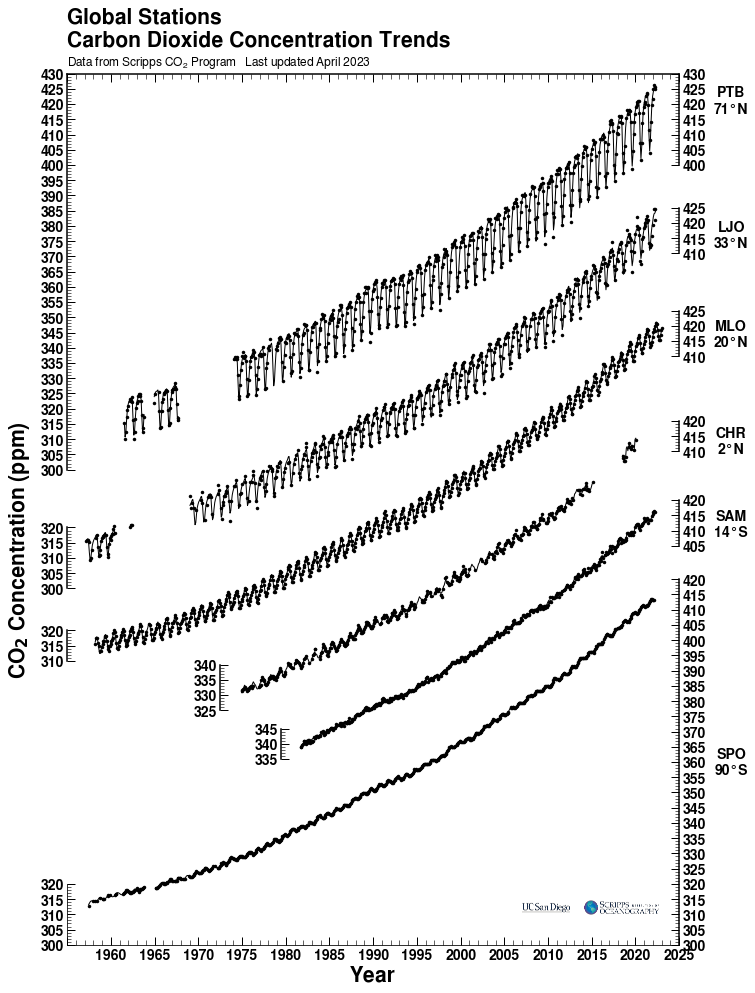

In [30]:
fig = plt.figure()

# ---------------------
# Set figure properties
# ---------------------

ax = fig.add_axes([0,0,1,1])

set_fig_props(ax, fig, xlabel, ylabel)


# Set configuration for each station
# Each station uses their own axes

# stations are ['spo', 'sam', 'chr', 'mlo', 'ljo', 'ptb']

axs = {}
axs_twin = {}
ytick_int = 5

graph_xlim = [xmin, xmax]
graph_ylim = [ymin, ymax]

# count: index of axs and axs_twin lists
# left_ylim: limits of the record's left y axis to show on the plot
# right_ylim: limits of the record's right y axis to show on the plot
# axes_setting: [left, bottom, width, height] of the new Axes
# ylabel_props = [sta_name, sta_degrees, xpos, ypos]

# --------
# Plot SPO
# --------
station = 'spo'
count =  0
left_ylim = [300,320]
right_ylim = [300,420]
axes_setting = [0, 0, 1, 0.5]
left_x_pos = 0
ylabel_props = [station.upper(), '90°S', 1.085, 0.5]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot SAM
# --------
station = 'sam'
count =  1
left_ylim = [335,345]
right_ylim = [405,420]
axes_setting = [0, 0.1, 1, 0.5]
left_x_pos = 0.35
ylabel_props = [station.upper(), '14°S', 1.085, 0.9]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot CHR
# --------
station = 'chr'
count =  2
left_ylim = [325,340]
right_ylim = [410,420]
axes_setting = [0, 0.2, 1, 0.5]
left_x_pos = 0.25
ylabel_props = [station.upper(), '2°N', 1.085, 0.91]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot MLO
# --------
station = 'mlo'
count =  3
left_ylim = [310,320]
right_ylim = [410,425]
axes_setting = [0, 0.32, 1, 0.5]
left_x_pos = 0
ylabel_props = [station.upper(), '20°N', 1.085, 0.94]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot LJO
# --------
station = 'ljo'
count =  4
left_ylim = [300,320]
right_ylim = [410,425]
axes_setting = [0, 0.45, 1, 0.5]
left_x_pos = 0
ylabel_props = [station.upper(), '33°N', 1.085, 0.93]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot PTB
# --------
station = 'ptb'
count =  5
left_ylim = [300,430]
right_ylim = [400,430]
axes_setting = [0, 0.6, 1, 0.5]
left_x_pos = 0
ylabel_props = [station.upper(), '71°N', 1.085, 0.97]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)


# --------------------------
# Congigure x axis of figure
# --------------------------

configure_fig_xaxis(axs, xmin, xmax)


# ---------------
# Add plot titles
# ---------------   
add_plot_title(ax, title1, title2, title3)

# --------------------
# Add SIO logo to plot
# --------------------
xpos = 0.73
ypos = 0.03

add_sio_logo(fig, logo_file, xpos, ypos)


# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()

save_plot_for_website(fig)


plt.show()